## Importanto dependências

In [1]:
from matplotlib import font_manager

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import matplotlib as mpl

## Baixando datasets (Windows)

In [ ]:
!pip install -q kaggle

In [ ]:
!cp ~/Downloads/kaggle.json %HOME%/.kaggle/kaggle.json

In [ ]:
DATADIR="data"
![ ! -d "$DATADIR" ] && mkdir "$DATADIR"

!kaggle datasets download -d anokas/kuzushiji -p "$DATADIR" --unzip

## Instalando fontes e adicionando ao matplotlib (Windows)

In [ ]:
!echo %HOME%;

In [ ]:
system = platform.system()

if system == 'Windows':
    font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
    font_path = os.path.join(os.path.expanduser('~'), 'AppData\Local\Microsoft\Windows\Fonts\TakaoPGothic.ttf')
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'TakaoPGothic'
    
    # Check if the font is installed
    print(font_manager.findfont("TakaoPGothic"))
# !ls C:\\Users\\medin\\anaconda3\\envs\\vision\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf
elif system == 'Linux':
    pass

## Funções auxiliares

In [24]:
# Loading classmap
df = pd.read_csv('data\k49_classmap.csv')
class_to_hiragana = df.to_dict(orient='index')

def get_hiragana(key):
  return class_to_hiragana[key]['char']

def flatten(x):
    n_samples, width, height, _ = x.shape
    
    return np.reshape(x, (n_samples, width*height))

def change_theme(color):
    mpl.rcParams['axes.labelcolor'] = color
    mpl.rcParams['xtick.color'] = color
    mpl.rcParams['ytick.color'] = color
    mpl.rcParams['text.color'] = color

---
## Pré-processamento dos dados

### Carregando dados e separando conjuntos de treino e teste

In [4]:
# Loading data from compressed files
x_train = np.load('data\\k49-train-imgs.npz')['arr_0'].astype('float32')
x_test = np.load('data\\k-49-test-imgs.npz')['arr_0'].astype('float32')

# Normalize data between 0 and 1
x_train /= 255
x_test /= 255

# Adding one extra "channel" dimension
x_train_expanded = np.expand_dims(x_train, axis=-1)
x_test_expanded = np.expand_dims(x_test, axis=-1)

# Loading labels from compressed files
y_train_original = np.load('data\k49-train-labels.npz')['arr_0']
y_test_original = np.load('data\k49-test-labels.npz')['arr_0']

n_classes = len(np.unique(y_train_original))

# One hot encoding for cross entropy loss (for later when training the model)
y_train = np_utils.to_categorical(y_train_original, n_classes)
y_test = np_utils.to_categorical(y_test_original, n_classes)

In [35]:
separator = f"\n{'---' * 35}\n"
print(f'Original training data shape: {x_train.shape} -  Expanded training data shape: {x_train_expanded.shape}')
print(f'Original testing data shape: {x_test.shape}   -  Expanded testing data shape: {x_test_expanded.shape}', end=separator)

print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0], end=separator)

print(f'Images resolution: {x_train.shape[1]}x{x_train.shape[2]}')
print('Number of classes: ', n_classes)

Original training data shape: (232365, 28, 28) -  Expanded training data shape: (232365, 28, 28, 1)
Original testing data shape: (38547, 28, 28)   -  Expanded testing data shape: (38547, 28, 28, 1)
---------------------------------------------------------------------------------------------------------
Number of training samples:  232365
Number of testing samples:  38547
---------------------------------------------------------------------------------------------------------
Images resolution: 28x28
Number of classes:  49


### Visualizando dados

In [25]:
def visualize_random_hiraganas(x, y, n_cols=10, n_rows=5, theme_path='dark'):
  n_imgs = n_cols * n_rows
  rand_idxs = np.random.randint(x.shape[0], size=n_imgs)

  rand_samples = x[rand_idxs]
  x = [get_hiragana(y[idx]) for idx in rand_idxs]

  fig = plt.figure(figsize=(n_cols, n_rows))
  plt.subplots_adjust(top=1)

  for i in range(n_imgs):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.set_title(x[i])

    ax.tick_params(
      axis='both',
      which='both',
      labelleft=False,
      labelbottom=False,
      bottom=False,
      left=False
    )
    
    ax.imshow(rand_samples[i], cmap='gray')

  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{n_imgs}_random_samples', transparent=True)
  plt.show()

def visualize_classes_imbalance(y, title=None, theme_path='dark'):
  classes, frequencies = np.unique(y, return_counts=True)
  sorted_lists = sorted(zip(frequencies, classes))
  frequencies, classes = [list(pair) for pair in zip(*sorted_lists)]

  hiraganas = [get_hiragana(class_) for class_ in classes]

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(111)
  ax1.scatter(hiraganas, frequencies)

  title = title or 'classes_imbalance'
  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{title}', transparent=True)
  plt.show()

def visualize_same_class_samples(x, y, n_classes=5, n_samples=5, theme_path='dark'):
  n_rows = n_classes
  n_columns = n_samples

  np.random.seed()

  classes_range = np.unique(y) # 0 a 48
  rand_classes = np.random.randint(classes_range[0], classes_range[-1], size=n_rows)

  fig = plt.figure(figsize=(n_columns, n_rows), dpi=100)
  plt.subplots_adjust(top=1)
  
  n_imgs = n_rows + n_columns  
  i = 1
  while i <= n_imgs:
    for class_ in rand_classes:
      rand_class_idxs = np.where(y == class_)[0][:n_columns]
      for sample_idx in rand_class_idxs:
        ax = fig.add_subplot(n_rows, n_columns, i)
        ax.set_title(get_hiragana(class_))

        ax.tick_params(
          axis='both',
          which='both',
          labelleft=False,
          labelbottom=False,
          bottom=False,
          left=False
        )
        
        ax.imshow(x[sample_idx], cmap='gray')
        i += 1
      
  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{n_rows}_classes_train_samples', transparent=True)
  plt.show()

In [ ]:
if not os.path.isdir('plots/dark'):
    os.makedirs('plots/dark')
if not os.path.isdir('plots/light'):
    os.makedirs('plots/light')

change_theme('black')
visualize_random_hiraganas(x_train, y_train_original, n_cols=15)
visualize_same_class_samples(x_train, y_train_original)
visualize_classes_imbalance(y_train_original, title='classes_imbalance_train_samples')
visualize_classes_imbalance(y_test_original, title='classes_imbalance_test_samples')

change_theme('white')
visualize_random_hiraganas(x_train, y_train_original, n_cols=15, theme_path='light')
visualize_same_class_samples(x_train, y_train_original, theme_path='light')
visualize_classes_imbalance(y_train_original, title='classes_imbalance_train_samples', theme_path='light')
visualize_classes_imbalance(y_test_original, title='classes_imbalance_test_samples', theme_path='light')

---
## Treinamento

### Criando modelos
A ideia é treinar vários modelos com diferentes parâmetros (número de camadas, filtros, tamanho dos filtros, otimizadores, etc) e comparar a performance, através da acurácia e da análise da curva ROC obtidas pelos modelos treinados.

Foi criada uma função **build_network_model** para gerar modelos, dados os parâmetros necessários, estes são:
- name               - nome usado nomear o arquivo h5 que irá guardar os pesos treinados de cada modelo
- network_layers     - lista de camadas sequenciais do modelo (camadas do módulo layers do keras)
- compilation_params - dict com parâmetros da compilação do modelo (otimizador, função de custo, etc)
- show_summary       - flag que faz a função imprimir uma sumarização do modelo construído

In [9]:
def build_network_model(name, network_layers, compilation_params, show_summary=False):
    model = keras.Sequential(
        network_layers,
        name
    )
    
    model.compile(**compilation_params)
    
    if show_summary:
        model.summary()
    
    return model

### Modelos
Dois tipos de modelos foram usados: redes neurais (NN) e redes neurais convolucionais (CNNs). São criadas um total de 6 redes neurais e 6 redes neurais convolucionais.<br>
As 6 redes neurais são:
- NN_1_sgd
- NN_2_sgd
- NN_1_adam
- NN_2_adam
- NN_dense
- NN_dense_batch_form

E as 6 redes neurais convolucionais são:
- CNN_1_sgd
- CNN_2_sgd
- CNN_1_adam
- CNN_2_adam
- CNN_dense
- CNN_dense_batch_form

O objetivo das 4 primeiras redes, de cada tipo de modelo, é comparar o impacto na performance que diferentes otimizadores e diferentes quantidades de camadas (para NNs) ou filtros (para CNNs) faz.<br>
As duas últimas redes de cada tipo de modelo são redes mais custosas computacionalmente, com muito mais camadas ou filtros; sendo que metade delas usa [Batch Normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) e a outra metade não. O objetivo é comparar se uma quantidade muito grande de camadas ou filtros, de fato melhora a performance consideravelmente, e se além disso, adicionar camadas de batch normalization ajuda.


In [10]:
neural_networks = [
    build_network_model(
        'NN_1_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_1_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense_batch_norm',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    )
]

conv_neural_networks = [
    build_network_model(
        'CNN_1_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_1_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_dense',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),    
    build_network_model(
        'CNN_dense_batch_norm',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    )
]

## Treinamento
O treinamento consiste em fazer o fit de cada modelo no conjunto de treino, separando 30% desse conjunto para validação e usando batches com 128 samples. Após o treinamento são salvos os pesos para que o treinamento não precise ser executado novamente no futuro, mas apenas carregado (vide seção [Carregando Modelos](#carregando-modelos) abaixo).

In [36]:
def train_model(model, training_params, output_path='weights'):
    model.fit(**training_params)
    
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
        
    model.save_weights(os.path.join(output_path, f'{model.name}.h5'))
    
    return model

In [ ]:
x_train_flattened = flatten(x_train_expanded)

nn_trained_models = [
    train_model(
        nn_model,
        {'x': x_train_flattened, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for nn_model in neural_networks
]

cnn_trained_models = [
    train_model(
        cnn_model,
        {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for cnn_model in conv_neural_networks
]

---
### Carregando modelos
Se os modelos já foram treinados, basta carregar seus pesos a partir dos arquivos .h5 para avaliá-los.

In [16]:
def load_model(models, model_name):
    model = list(filter(lambda x: x.name == model_name, models))[0]
    model.load_weights(f'weights/{model_name}.h5')
    
    return model

weights_filenames = os.listdir('weights')

nn_trained_models = [load_model(neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('NN')]
cnn_trained_models = [load_model(conv_neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('CNN')]

['NN_1_adam', 'NN_1_sgd', 'NN_2_adam', 'NN_2_sgd', 'NN_dense', 'NN_dense_batch_norm', 'CNN_1_adam', 'CNN_1_sgd', 'CNN_2_adam', 'CNN_2_sgd', 'CNN_dense', 'CNN_dense_batch_norm']


## Avaliação dos Modelos

### Acurácia
A avaliação dos modelos irá começar usando métricas mais simples: acurácia e loss.

In [42]:
def evaluate_model(model, x_test, y_test, should_flatten=False) -> tuple[float, float]:
    if should_flatten:
        x_test = flatten(x_test)
        
    return model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [50]:
nn_losses = []
nn_accuracies = []
cnn_losses = []
cnn_accuracies = []

for model in nn_trained_models:    
    loss, acc = evaluate_model(model, x_test_expanded, y_test, should_flatten=True)
    nn_losses.append(loss)
    nn_accuracies.append(acc)
    
for model in cnn_trained_models:
    loss, acc = evaluate_model(model, x_test_expanded, y_test)
    cnn_losses.append(loss)
    cnn_accuracies.append(acc)

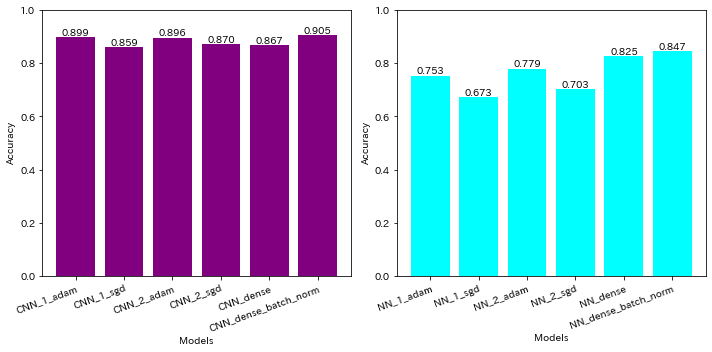

In [149]:
cnn_models_names = [trained_model.name for trained_model in cnn_trained_models]
nn_models_names = [trained_model.name for trained_model in nn_trained_models]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

subplots = [
    {'ax': axes[0], 'xtick_labels': cnn_models_names, 'ylabel': 'Accuracy', 'data': cnn_accuracies, 'color': 'purple'},
    {'ax': axes[1], 'xtick_labels': nn_models_names, 'ylabel': 'Accuracy', 'data': nn_accuracies, 'color': 'cyan'},
]

for subplot in subplots:
    ax = subplot['ax']
    xtick_labels = subplot['xtick_labels']
    ylabel = subplot['ylabel']
    data = subplot['data']
    color = subplot['color']
    
    ax.set_ylim([0, 1])
    ax.bar(xtick_labels, data, color=color)
    ax.set_xticks(xtick_labels)
    ax.set_xticklabels(labels=xtick_labels, rotation=20, ha='right', rotation_mode='anchor')
    ax.set(xlabel='Models', ylabel=ylabel)
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.3f')

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig('plots/accuracies.jpg')
plt.show()

Dos gráficos de barra plotados, podemos observar que:
- todas CNNs apresentam acurácia superior às NNs
- os modelos que usaram o SGD como otimizador obtiveram menor acurácia, comparados com os que usaram ADAM
- a CNN mais densa com Batch Normalization (e de longe a mais custosa computacionalmente) obteve acurácia muito semelhante a CNNs menos densas e sem Batch Normalization
- já a NN mais densa com Batch Normalization se saiu, levemente, melhor quando comparadas com as outras NNs

### TODO AUC e Curva ROC
Porém, como mencionado anteriormente, o dataset é (propositalmente) desbalanceado, com algumas classes possuindo muito menos exemplos que outras. Portanto apenas analisar a acurária obtida pelos modelos não é suficiente para sumarizar seus desempenhos, é preciso usar métricas que levam em consideração o desbalanceio do dataset.<br>
...............................

In [121]:
# def plot_roc_curve(trained_model, x_test, y_test):
trained_model = nn_trained_models[0]
x = flatten(x_test_expanded)
y = y_test
y_score = trained_model.predict(x)

# fpr = False Positive Rate
# tpr = True Positive Rate
def get_auc(_class):
    fpr, tpr, _ = roc_curve(y[:, _class], y_score[:, _class])
    return auc(fpr, tpr)

classes, frequencies = np.unique(y_train_original, return_counts=True)
sorted_lists = sorted(zip(frequencies, classes))
frequencies, classes = [pair for pair in  zip(*sorted_lists)]

auc_4_all_classes = [get_auc(_class) for _class in classes]
hiraganas = [get_hiragana(_class) for _class in classes]

<BarContainer object of 49 artists>

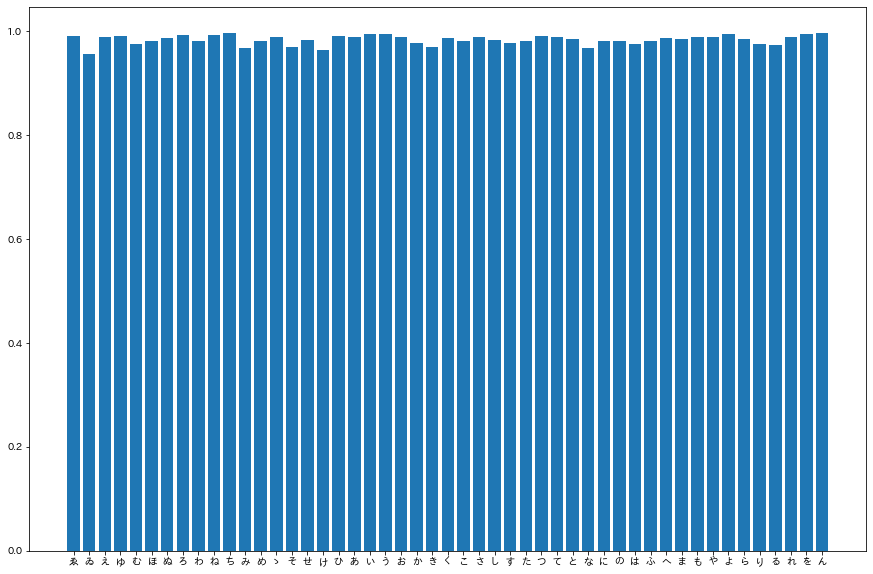

In [122]:
fig = plt.figure(figsize=(15, 10))
plt.bar(
    hiraganas,
    auc_4_all_classes
)

In [ ]:
plot_roc_curve(nn_trained_models[0], flatten(x_test_expanded), y_test)

### TODO Plots interessantes do que os modelos erram e acertam (super simples para de complicar esse trem)

In [9]:
def generate_random_index(x):
    while True:
        yield np.random.randint(0, x.shape[0], size=1)[0]

def show_random_predictions(trained_models, n_predictions, x_test):
    n_rows = len(trained_models)
    n_cols = n_predictions
    
    fig, big_axes = plt.subplots(figsize=(15, 15), ncols=1, nrows=n_rows, sharey=True)

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_title(trained_models[row-1].name, fontsize=16)

        # Turn off axis lines and ticks of the big subplot 
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        
        # removes the white frame
        big_ax._frameon = False
        
    idx_generator = generate_random_index(x_test)
#     fig = plt.figure(figsize=(n_cols, n_rows), dpi=150)
    
    i = 1
    while i <= n_predictions:
        idx = next(idx_generator)
        
        for pos, model in enumerate(trained_models[-1:]):
            probabilities = model.predict(x_test[idx:idx+1])

            predicted_class = get_hiragana(np.argmax(probabilities))
            real_class      = get_hiragana(np.argmax(y_test[0]))
            
            # Add to subplot
            ax = fig.add_subplot(n_rows, n_cols, i + n_cols*pos)
            ax.set_title(f'predicted class:  {predicted_class}\nreal_class: {real_class}')
            
            ax.tick_params(
              axis='both',
              which='both',
              labelleft=False,
              labelbottom=False,
              bottom=False,
              left=False
            )
            
            ax.imshow(x_test[idx], cmap='gray')
            
        i += 1
        
    fig.set_facecolor('w')
    plt.tight_layout()
    plt.savefig('testes.jpg')
    plt.show()

In [ ]:
show_random_predictions(nn_trained_models + cnn_trained_models, 5, x_test_expanded)
# x_test_flattened = flatten(x_test_expanded)

# show_random_predictions(trained_models[0], x_test_flattened, y_test, x_test)
# show_random_predictions(trained_models[5], x_test_expanded, y_test, x_test)